In [1]:
import os
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from langchain_ollama import ChatOllama

load_dotenv()

# llm = ChatOpenAI(
#                     temperature=0,
#                     max_tokens=4096,
#                     presence_penalty=1.2,
#                     model='deepseek-chat',
#                     openai_api_key=os.getenv('DEEPSEEK_API_KEY'),
#                     openai_api_base="https://api.deepseek.com/v1",
#                 )

model = ChatOllama(
                    temperature=0,
                    num_predict=4096,
                    repeat_penalty=1.2,
                    model="llama3.2:3b"
                )

# Define graph

In [2]:
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, MessagesState, START


def call_model(state: MessagesState):
    response = model.invoke(state["messages"])
    return {"messages": response}


builder = StateGraph(MessagesState)
builder.add_node("call_model", call_model)
builder.add_edge(START, "call_model")
graph = builder.compile()

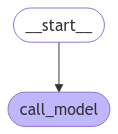

In [3]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [4]:
input_message = {"type": "user", "content": "hi! I'm bob"}
for chunk in graph.stream({"messages": [input_message]}, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

input_message = {"type": "user", "content": "what's my name?"}
for chunk in graph.stream({"messages": [input_message]}, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

hi! I'm bob
================================== Ai Message ==================================

Hi Bob! It's nice to meet you. Is there something I can help you with, or would you like to chat?
================================ Human Message =================================

what's my name?
================================== Ai Message ==================================

I don't have any information about your identity, so I'm not aware of what your name is. This conversation just started, and we haven't established a connection or shared personal details yet. Would you like to share your name with me now?


In [8]:
graph.invoke({"messages": [input_message]}, stream_mode="values")["messages"][-1].pretty_print()

================================== Ai Message ==================================

I don't have any information about your identity, so I'm not aware of what your name is. This conversation just started, and we haven't established a connection or shared personal details yet. Would you like to share your name with me now?


# Add persistence

In [9]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()
graph = builder.compile(checkpointer=memory)
# If you're using LangGraph Cloud or LangGraph Studio, you don't need to pass the checkpointer when compiling the graph, since it's done automatically.

In [10]:
config = {"configurable": {"thread_id": "1"}}
input_message = {"type": "user", "content": "hi! I'm bob"}
for chunk in graph.stream({"messages": [input_message]}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

hi! I'm bob
================================== Ai Message ==================================

Hi Bob! It's nice to meet you. Is there something I can help you with, or would you like to chat?


In [11]:
input_message = {"type": "user", "content": "what's my name?"}
for chunk in graph.stream({"messages": [input_message]}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

what's my name?
================================== Ai Message ==================================

Your name is... Bob! (I remember from our conversation at the start) How are you doing today, Bob?


In [12]:
input_message = {"type": "user", "content": "what's my name?"}
for chunk in graph.stream(
    {"messages": [input_message]},
    {"configurable": {"thread_id": "2"}},
    stream_mode="values",
):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

what's my name?
================================== Ai Message ==================================

I don't have any information about your identity, so I'm not aware of what your name is. This conversation just started, and we haven't established a connection or shared personal details yet. Would you like to share your name with me now?
